# Casting Defects Detection using Anomaly Detection

This project aims to develop outlier or novelty detection models that can detect casting defects. The difference between outlier and novelty detection is as follows:<br>
Source: [2.7. Novelty and Outlier Detection](https://scikit-learn.org/stable/modules/outlier_detection.html)

<strong>Outlier detection</strong>:
The training data contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

<strong>Novelty detection</strong>:
The training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty.

# Casting Defects with Isolation Forest (Outlier Detection)

The first model that we will be using is isolation forest. For this model, we will apply anomaly detection method.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest

The images that we will work with are greyscale images. Let's examine one image from the list of images.

In [2]:
filePath = os.path.join('casting_512x512', 'def_front')
p1 = os.listdir(filePath)[10]

## Feature Engineering

 Let's study its greyscale distribution.

In [3]:
img = cv2.imread(filePath + '\\' + p1)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
print(hist.shape)

(256, 1)


As it is a greyscale image, it has 256 values/features.

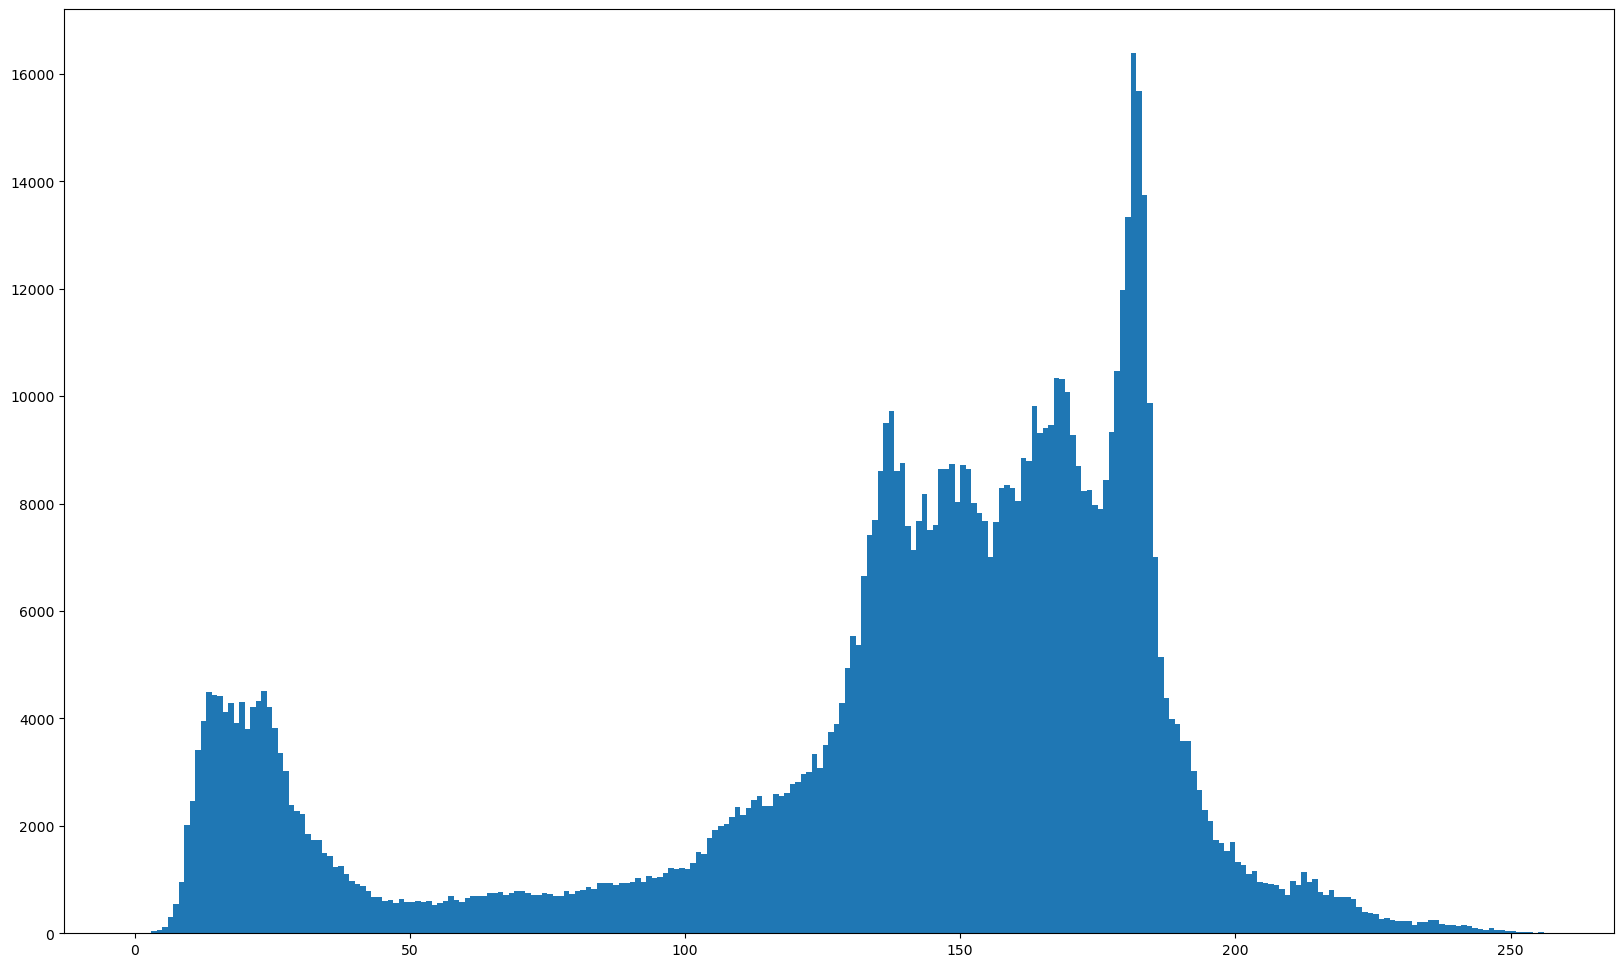

In [4]:
img = cv2.imread(filePath + '\\' + p1)
plt.figure(figsize=(20, 12))
plt.hist(img.ravel(),256,[0,256])
plt.show()

Let's normalise the histogram values to make them comparable.

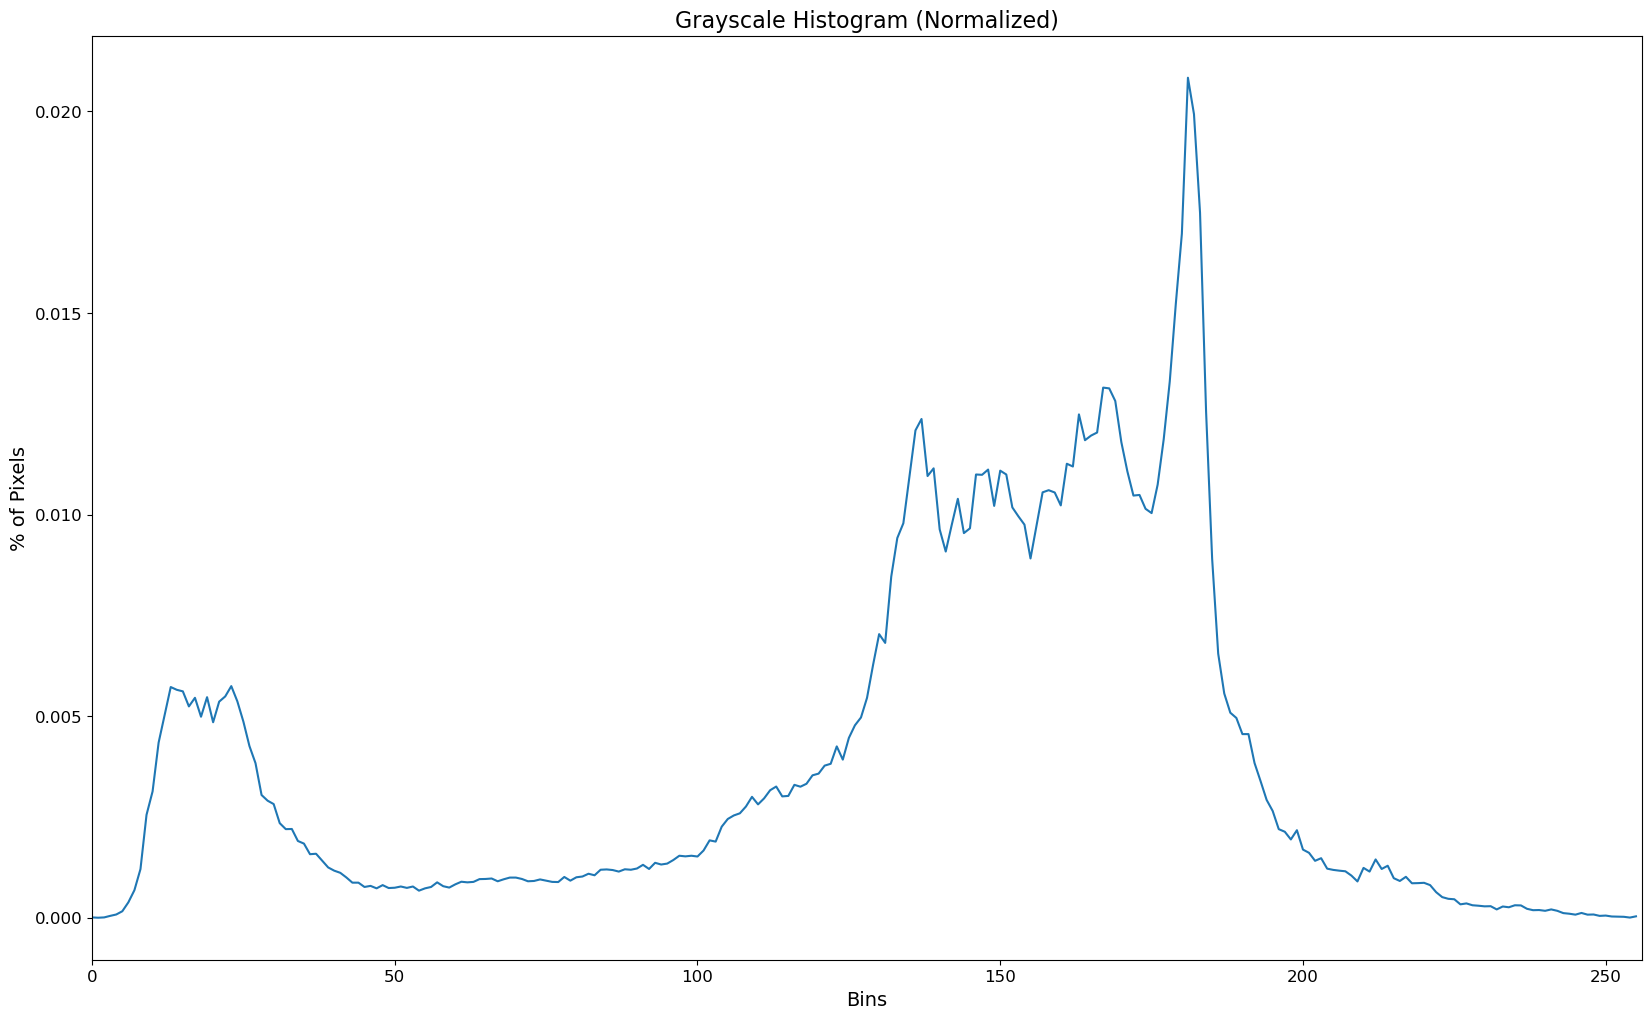

In [5]:
# normalize the histogram
hist /= hist.sum()

# plot the normalized histogram
plt.figure(figsize=(20, 12))
plt.title("Grayscale Histogram (Normalized)", fontsize=16)
plt.xlabel("Bins", fontsize=14)
plt.ylabel("% of Pixels", fontsize=14)
plt.plot(hist)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0, 256])
plt.show()

In [6]:
def quantify_image(img):
    # compute a greyscale histogram over an image and normalize it
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [7]:
def transform_data_from_path(imagePath):
    # convert all images in the imagePath
    # to greyscale histogram values (normalised)
    data = []

    # loop over the imagePath directory
    for imageName in os.listdir(imagePath):
        # load the image
        image = cv2.imread(imagePath + '\\' + imageName)
        # quantify the image and update the data list
        features = quantify_image(image)
        data.append(features)
    return np.array(data)

In [8]:
# The paths to the images
defect_path = os.path.join('casting_512x512', 'def_front')
normal_path = os.path.join('casting_512x512', 'ok_front')

In [9]:
defect = transform_data_from_path(defect_path)
normal = transform_data_from_path(normal_path)

print('Defect:', len(defect))
print('Normal:', len(normal))

Defect: 781
Normal: 519


For easy splitting of data, we will reduce the size of the defective casting so that it is equal to that of normal casting.

In [10]:
defect = defect[:519]
print(len(defect))

519


In [11]:
defect_train, defect_test = train_test_split(defect, test_size=0.2, random_state=42)
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=42)

print('Defect')
print('Train:', len(defect_train))
print('Test:', len(defect_test))
print()
print('Normal')
print('Train:', len(normal_train))
print('Test:', len(normal_test))

Defect
Train: 415
Test: 104

Normal
Train: 415
Test: 104


In [12]:
train = np.concatenate((normal_train, defect_train), axis=0)
print(train.shape)

(830, 256)


## Model Training

In [13]:
model = IsolationForest(n_estimators=100, 
                        contamination=len(defect_train)/len(train), 
                        random_state=42,
                        max_features=int(np.sqrt(256)),
                        n_jobs=-1)
model.fit(train)

IsolationForest(contamination=0.5, max_features=16, n_jobs=-1, random_state=42)

## Model Testing

Let's determine the precision, recall, and accuracy.

In [14]:
test = np.concatenate((normal_test, defect_test), axis=0)
print(test.shape)

(208, 256)


A predicted value of 1 means normal casting while -1 means defective casting. To ease metrics evaluation later, we will create a list of actual test labels.

In [15]:
test_labels = np.ones(len(test))
test_labels[-len(defect_test):] = -1

# 1 means normal casting while -1 means defective casting
preds = model.predict(test)

In [16]:
print(classification_report(test_labels, preds, target_names=['Defective', 'Normal']))

              precision    recall  f1-score   support

   Defective       0.51      0.50      0.50       104
      Normal       0.51      0.52      0.51       104

    accuracy                           0.51       208
   macro avg       0.51      0.51      0.51       208
weighted avg       0.51      0.51      0.51       208



We can see our initial Isolation Forest model does not perform well. Let's tune the n_trees hyperparameter.

## Hyperparameter Tuning

In [17]:
optimal_nt = 0
max_accuracy = -1
for n_trees in range(30, 50, 1): 
    model = IsolationForest(n_estimators=n_trees, 
                            contamination=len(defect_train)/len(train), 
                            random_state=42,
                            max_features=int(np.sqrt(256)),
                            n_jobs=-1)
    model.fit(train)
    preds = model.predict(test)
    accuracy = accuracy_score(test_labels, preds)
    if(accuracy > max_accuracy):
        max_accuracy = accuracy
        optimal_nt = n_trees
    print(f'n_trees: {n_trees}, accuracy: {accuracy_score(test_labels, preds)}')

n_trees: 30, accuracy: 0.5528846153846154
n_trees: 31, accuracy: 0.5528846153846154
n_trees: 32, accuracy: 0.5480769230769231
n_trees: 33, accuracy: 0.5721153846153846
n_trees: 34, accuracy: 0.5721153846153846
n_trees: 35, accuracy: 0.5576923076923077
n_trees: 36, accuracy: 0.5384615384615384
n_trees: 37, accuracy: 0.5625
n_trees: 38, accuracy: 0.5528846153846154
n_trees: 39, accuracy: 0.5576923076923077
n_trees: 40, accuracy: 0.5817307692307693
n_trees: 41, accuracy: 0.5673076923076923
n_trees: 42, accuracy: 0.5673076923076923
n_trees: 43, accuracy: 0.5480769230769231
n_trees: 44, accuracy: 0.5384615384615384
n_trees: 45, accuracy: 0.5432692307692307
n_trees: 46, accuracy: 0.5336538461538461
n_trees: 47, accuracy: 0.5192307692307693
n_trees: 48, accuracy: 0.5192307692307693
n_trees: 49, accuracy: 0.5288461538461539


The best isolation forest model occurs at n_trees = 40, but the accuracy of 0.58 is still low.

In [18]:
model = IsolationForest(n_estimators=optimal_nt, 
                        contamination=len(defect_train)/len(train), 
                        random_state=42,
                        max_features=int(np.sqrt(256)),
                        n_jobs=-1)
model.fit(train)
preds = model.predict(test)
print(classification_report(test_labels, preds, target_names=['Defective', 'Normal']))

              precision    recall  f1-score   support

   Defective       0.58      0.59      0.58       104
      Normal       0.58      0.58      0.58       104

    accuracy                           0.58       208
   macro avg       0.58      0.58      0.58       208
weighted avg       0.58      0.58      0.58       208



With further tuning, Isolation Forest model does not work well on the image set.